In [1]:
#inputdir = "/kaggle/input/ufo-sightings/"
#outdir = "/kaggle/working"
inputdir = "./ufo_in"
outdir = "./ufo_out"
!ls {inputdir}
!mkdir -p {outdir}

scrubbed.csv


In [2]:
%%time

#%pip install maptiles ggshow
#%conda install -c conda-forge r-base
#!Rscript -e "install.packages('ggplot2', repos='https://cloud.r-project.org/')"

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.4 µs


In [3]:
import os
import re
import sys
import random
from datetime import datetime, timedelta
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import pyproj
import geopandas as gpd
import folium
from maptiles import draw_map
from ggshow import ggshow
%matplotlib inline

/home/kota/venv/sandbox/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
# we will be using the scrubbed data because the complete data contains varying number of columns per row
# and some error-like rows
tmp = pd.read_csv(os.path.join(inputdir, "scrubbed.csv"))
tmp = tmp.rename(columns={
     "duration (seconds)":"duration_sec"
    ,"duration (hours/min)":"duration_word"
    ,"date posted":"date_posted"
})
tmp.columns = tmp.columns.str.strip().str.lower()
print(tmp.dtypes)
tmp.head()

datetime          object
city              object
state             object
country           object
shape             object
duration_sec      object
duration_word     object
comments          object
date_posted       object
latitude          object
longitude        float64
dtype: object


/home/kota/venv/sandbox/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration_sec duration_word  \
0         2700    45 minutes   
1         7200       1-2 hrs   
2           20    20 seconds   
3           20      1/2 hour   
4          900    15 minutes   

                                            comments date_posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

In [5]:
def _to_datetime(d):
    r = re.search(r"^(\d{1,2})/(\d{1,2})/(\d{4}) (\d{1,2}):(\d{1,2})$", d.strip())
    if r is None:
        print("Unexpected datetime format '{}'".format(d), file=sys.stderr)
    day = datetime(int(r.group(3)), int(r.group(1)), int(r.group(2)))
    time = timedelta(hours=int(r.group(4)), minutes=int(r.group(5)))
    return day + time

def _to_date(d):
    r = re.search(r"^(\d{1,2})/(\d{1,2})/(\d{4})$", d.strip())
    if r is None:
        print("Unexpected date format '{}'".format(d), file=sys.stderr)
    day = datetime(int(r.group(3)), int(r.group(1)), int(r.group(2)))
    return day

# data cleaning
x = tmp.copy()

x.datetime = tmp.datetime.apply(_to_datetime)
x.date_posted = tmp.date_posted.apply(_to_date)

x.duration_sec = tmp.duration_sec.astype(str).str.replace("`", "").astype(float)
x.latitude = tmp.latitude.astype(str).str.replace("q", "", regex=False).astype(float)

In [6]:
# check if we have generated extra missing values
pd.concat((tmp.isna().sum(), x.isna().sum()), axis=1)

0     1
datetime          0     0
city              0     0
state          5797  5797
country        9670  9670
shape          1932  1932
duration_sec      0     0
duration_word     0     0
comments         15    15
date_posted       0     0
latitude          0     0
longitude         0     0

In [7]:
# create web-mercator projected coordinates
t = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
tmp = [t.transform(lon, lat) for lon,lat in zip(x.longitude, x.latitude)]
x["longitude_proj"] = [a for a,b in tmp]
x["latitude_proj"] = [b for a,b in tmp]
x.head()

datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration_sec duration_word  \
0        2700.0    45 minutes   
1        7200.0       1-2 hrs   
2          20.0    20 seconds   
3          20.0      1/2 hour   
4         900.0    15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16  29.384210   
2  Green/Orange circular disc over Chester&#44 En...  2008-01-21  53.200000   
3  My older brother and twin sister were leaving ...  2004-01-17  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22  21.418056   

    longitude  longitude_proj  latitude_proj  
0  -97.941111   -1.090275e+07   3.488527e+06  
1  -98.581082   -1.097400e+07   3.424639e+06  
2   -2.916667   -3.246819e+05   7.020079e+06  
3  -96.645833   -1.075856e+07   3.372889e+06  
4 -157.803611   -1.756662e+07   2.441798e+06

In [8]:
x = gpd.GeoDataFrame(x, geometry=gpd.points_from_xy(x.longitude, x.latitude), crs="EPSG:4326")
x.head()

datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration_sec duration_word  \
0        2700.0    45 minutes   
1        7200.0       1-2 hrs   
2          20.0    20 seconds   
3          20.0      1/2 hour   
4         900.0    15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16  29.384210   
2  Green/Orange circular disc over Chester&#44 En...  2008-01-21  53.200000   
3  My older brother and twin sister were leaving ...  2004-01-17  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22  21.418056   

    longitude  longitude_proj  latitude_proj                     geometry  
0  -97.941111   -1.090275e+07   3.488527e+06   POINT (-97.94111 29.88306)  
1  -98.581082   -1.097400e+07   3.424639e+06   POINT (-98.58108 29.38421)  
2   -2.916667   -3.246819e+05   7.020079e+06    POINT (-2.91667 53.20000)  
3  -96.645833   -1.075856e+07   3.372889e+06   POINT (-96.64583 28.97833)  
4 -157.803611   -1.756662e+07   2.441798e+06  POINT (-157.80361 21.41806)

In [9]:
x.describe(datetime_is_numeric=True)

datetime  duration_sec  \
count                          80332  8.033200e+04   
mean   2004-05-17 04:07:35.261166336  9.016889e+03   
min              1906-11-11 00:00:00  1.000000e-03   
25%              2001-08-02 21:45:00  3.000000e+01   
50%              2006-11-22 04:05:00  1.800000e+02   
75%              2011-06-21 00:30:00  6.000000e+02   
max              2014-05-08 18:45:00  9.783600e+07   
std                              NaN  6.202168e+05   

                         date_posted      latitude     longitude  \
count                          80332  80332.000000  80332.000000   
mean   2007-07-28 02:15:17.074142464     38.124416    -86.772885   
min              1998-03-07 00:00:00    -82.862752   -176.658056   
25%              2003-11-26 00:00:00     34.134722   -112.073333   
50%              2007-11-28 00:00:00     39.411111    -87.903611   
75%              2011-10-10 00:00:00     42.788333    -78.755000   
max              2014-05-08 00:00:00     72.700000    178.441900   
std                              NaN     10.469585     39.697205   

       longitude_proj  latitude_proj  
count    8.033200e+04   8.033200e+04  
mean    -9.659513e+06   4.665483e+06  
min     -1.966548e+07  -1.769775e+07  
25%     -1.247595e+07   4.046906e+06  
50%     -9.785385e+06   4.780732e+06  
75%     -8.766966e+06   5.279809e+06  
max      1.986406e+07   1.201022e+07  
std      4.419073e+06   1.383039e+06

In [10]:
# US county borders
!wget https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip
!unzip -o cb_2018_us_county_20m.zip
cb = gpd.read_file("cb_2018_us_county_20m.shp").to_crs("EPSG:4326")
display(cb)

x = x.sjoin(cb, how="left", predicate="intersects")
x

--2022-05-13 16:59:30--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip
Resolving www2.census.gov (www2.census.gov)... 2600:1409:3000:39e::208c, 2600:1409:3000:39a::208c, 23.5.253.30
Connecting to www2.census.gov (www2.census.gov)|2600:1409:3000:39e::208c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_county_20m.zip.7’

cb_2018_us_county_2     [     <=>            ] 844.28K   935KB/s    in 0.9s    

2022-05-13 16:59:32 (935 KB/s) - ‘cb_2018_us_county_20m.zip.7’ saved [864539]

Archive:  cb_2018_us_county_20m.zip
  inflating: cb_2018_us_county_20m.shp.ea.iso.xml  
  inflating: cb_2018_us_county_20m.shp.iso.xml  
  inflating: cb_2018_us_county_20m.shp  
  inflating: cb_2018_us_county_20m.shx  
  inflating: cb_2018_us_county_20m.dbf  
  inflating: cb_2018_us_county_20m.prj  
 extracting: cb_2018_us_county_20m.cpg  


STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID      NAME LSAD  \
0         37      017  01026336  0500000US37017  37017    Bladen   06   
1         37      167  01025844  0500000US37167  37167    Stanly   06   
2         39      153  01074088  0500000US39153  39153    Summit   06   
3         42      113  01213687  0500000US42113  42113  Sullivan   06   
4         48      459  01384015  0500000US48459  48459    Upshur   06   
...      ...      ...       ...             ...    ...       ...  ...   
3215      38      005  01034216  0500000US38005  38005    Benson   06   
3216      72      079  01804520  0500000US72079  72079     Lajas   13   
3217      31      159  00835901  0500000US31159  31159    Seward   06   
3218      37      023  01008539  0500000US37023  37023     Burke   06   
3219      13      261  00343504  0500000US13261  13261    Sumter   06   

           ALAND     AWATER                                           geometry  
0     2265887723   33010866  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  
1     1023370459   25242751  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  
2     1069181981   18958267  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  
3     1165338428    6617028  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  
4     1509910100   24878888  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  
...          ...        ...                                                ...  
3215  3596569006  131708143  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  
3216   155287827  106643202  POLYGON ((-67.10904 18.05608, -67.06791 18.066...  
3217  1479995670   11542537  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  
3218  1311146878   20719896  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  
3219  1250630094   25227638  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  

[3220 rows x 10 columns]

datetime                  city state country     shape  \
0     1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1     1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2     1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3     1956-10-10 21:00:00                  edna    tx      us    circle   
4     1960-10-10 20:00:00               kaneohe    hi      us     light   
...                   ...                   ...   ...     ...       ...   
80327 2013-09-09 21:15:00             nashville    tn      us     light   
80328 2013-09-09 22:00:00                 boise    id      us    circle   
80329 2013-09-09 22:00:00                  napa    ca      us     other   
80330 2013-09-09 22:20:00                vienna    va      us    circle   
80331 2013-09-09 23:00:00                edmond    ok      us     cigar   

       duration_sec duration_word  \
0            2700.0    45 minutes   
1            7200.0       1-2 hrs   
2              20.0    20 seconds   
3              20.0      1/2 hour   
4             900.0    15 minutes   
...             ...           ...   
80327         600.0    10 minutes   
80328        1200.0    20 minutes   
80329        1200.0          hour   
80330           5.0     5 seconds   
80331        1020.0    17 minutes   

                                                comments date_posted  \
0      This event took place in early fall around 194...  2004-04-27   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16   
2      Green/Orange circular disc over Chester&#44 En...  2008-01-21   
3      My older brother and twin sister were leaving ...  2004-01-17   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...  2013-09-30   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...  2013-09-30   
80329                                       Napa UFO&#44  2013-09-30   
80330  Saw a five gold lit cicular craft moving fastl...  2013-09-30   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...  2013-09-30   

        latitude  ...  index_right  STATEFP  COUNTYFP  COUNTYNS  \
0      29.883056  ...       1178.0       48       209  01383890   
1      29.384210  ...       1409.0       48       029  01383800   
2      53.200000  ...          NaN      NaN       NaN       NaN   
3      28.978333  ...       3005.0       48       239  01383905   
4      21.418056  ...       1166.0       15       003  00365281   
...          ...  ...          ...      ...       ...       ...   
80327  36.165833  ...       1036.0       47       037  01639737   
80328  43.613611  ...        420.0       16       001  00395066   
80329  38.297222  ...        535.0       06       055  00277292   
80330  38.901111  ...       1991.0       51       059  01480119   
80331  35.652778  ...        854.0       40       109  01101842   

             AFFGEOID  GEOID      NAME LSAD         ALAND        AWATER  
0      0500000US48209  48209      Hays   06  1.755979e+09  5.037743e+06  
1      0500000US48029  48029     Bexar   06  3.212141e+09  4.107971e+07  
2                 NaN    NaN       NaN  NaN           NaN           NaN  
3      0500000US48239  48239   Jackson   06  2.148247e+09  7.103957e+07  
4      0500000US15003  15003  Honolulu   06  1.555454e+09  4.055036e+09  
...               ...    ...       ...  ...           ...           ...  
80327  0500000US47037  47037  Davidson   06  1.304033e+09  5.659044e+07  
80328  0500000US16001  16001       Ada   06  2.724688e+09  2.217618e+07  
80329  0500000US06055  06055      Napa   06  1.938114e+09  1.043008e+08  
80330  0500000US51059  51059   Fairfax   06  1.012684e+09  4.012692e+07  
80331  0500000US40109  40109  Oklahoma   06  1.835846e+09  2.473059e+07  

[80332 rows x 24 columns]

In [11]:
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
statefips = """
Name 	Postal Code 	FIPS
Alabama 	AL 	01
Alaska 	AK 	02
Arizona 	AZ 	04
Arkansas 	AR 	05
California 	CA 	06
Colorado 	CO 	08
Connecticut 	CT 	09
Delaware 	DE 	10
Florida 	FL 	12
Georgia 	GA 	13
Hawaii 	HI 	15
Idaho 	ID 	16
Illinois 	IL 	17
Indiana 	IN 	18
Iowa 	IA 	19
Kansas 	KS 	20
Kentucky 	KY 	21
Louisiana 	LA 	22
Maine 	ME 	23
Maryland 	MD 	24
Massachusetts 	MA 	25
Michigan 	MI 	26
Minnesota 	MN 	27
Mississippi 	MS 	28
Missouri 	MO 	29
Montana 	MT 	30
Nebraska 	NE 	31
Nevada 	NV 	32
New Hampshire 	NH 	33
New Jersey 	NJ 	34
New Mexico 	NM 	35
New York 	NY 	36
North Carolina 	NC 	37
North Dakota 	ND 	38
Ohio 	OH 	39
Oklahoma 	OK 	40
Oregon 	OR 	41
Pennsylvania 	PA 	42
Rhode Island 	RI 	44
South Carolina 	SC 	45
South Dakota 	SD 	46
Tennessee 	TN 	47
Texas 	TX 	48
Utah 	UT 	49
Vermont 	VT 	50
Virginia 	VA 	51
Washington 	WA 	53
West Virginia 	WV 	54
Wisconsin 	WI 	55
Wyoming 	WY 	56
American Samoa 	AS 	60
Guam 	GU 	66
Northern Mariana Islands 	MP 	69
Puerto Rico 	PR 	72
Virgin Islands 	VI 	78
"""
statefips = pd.read_csv(StringIO(statefips.strip()), sep="\t", dtype=str)
statefips.columns = ["state_name", "state_code", "state_fips"]
display(statefips)

x = pd.merge(x, statefips, how="left", left_on="STATEFP", right_on="state_fips")
x

state_name state_code state_fips
0                    Alabama         AL          01
1                     Alaska         AK          02
2                    Arizona         AZ          04
3                   Arkansas         AR          05
4                 California         CA          06
5                   Colorado         CO          08
6                Connecticut         CT          09
7                   Delaware         DE          10
8                    Florida         FL          12
9                    Georgia         GA          13
10                    Hawaii         HI          15
11                     Idaho         ID          16
12                  Illinois         IL          17
13                   Indiana         IN          18
14                      Iowa         IA          19
15                    Kansas         KS          20
16                  Kentucky         KY          21
17                 Louisiana         LA          22
18                     Maine         ME          23
19                  Maryland         MD          24
20             Massachusetts         MA          25
21                  Michigan         MI          26
22                 Minnesota         MN          27
23               Mississippi         MS          28
24                  Missouri         MO          29
25                   Montana         MT          30
26                  Nebraska         NE          31
27                    Nevada         NV          32
28             New Hampshire         NH          33
29                New Jersey         NJ          34
30                New Mexico         NM          35
31                  New York         NY          36
32            North Carolina         NC          37
33              North Dakota         ND          38
34                      Ohio         OH          39
35                  Oklahoma         OK          40
36                    Oregon         OR          41
37              Pennsylvania         PA          42
38              Rhode Island         RI          44
39            South Carolina         SC          45
40              South Dakota         SD          46
41                 Tennessee         TN          47
42                     Texas         TX          48
43                      Utah         UT          49
44                   Vermont         VT          50
45                  Virginia         VA          51
46                Washington         WA          53
47             West Virginia         WV          54
48                 Wisconsin         WI          55
49                   Wyoming         WY          56
50            American Samoa         AS          60
51                      Guam         GU          66
52  Northern Mariana Islands         MP          69
53               Puerto Rico         PR          72
54            Virgin Islands         VI          78

datetime                  city state country     shape  \
0     1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1     1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2     1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3     1956-10-10 21:00:00                  edna    tx      us    circle   
4     1960-10-10 20:00:00               kaneohe    hi      us     light   
...                   ...                   ...   ...     ...       ...   
80327 2013-09-09 21:15:00             nashville    tn      us     light   
80328 2013-09-09 22:00:00                 boise    id      us    circle   
80329 2013-09-09 22:00:00                  napa    ca      us     other   
80330 2013-09-09 22:20:00                vienna    va      us    circle   
80331 2013-09-09 23:00:00                edmond    ok      us     cigar   

       duration_sec duration_word  \
0            2700.0    45 minutes   
1            7200.0       1-2 hrs   
2              20.0    20 seconds   
3              20.0      1/2 hour   
4             900.0    15 minutes   
...             ...           ...   
80327         600.0    10 minutes   
80328        1200.0    20 minutes   
80329        1200.0          hour   
80330           5.0     5 seconds   
80331        1020.0    17 minutes   

                                                comments date_posted  \
0      This event took place in early fall around 194...  2004-04-27   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16   
2      Green/Orange circular disc over Chester&#44 En...  2008-01-21   
3      My older brother and twin sister were leaving ...  2004-01-17   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...  2013-09-30   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...  2013-09-30   
80329                                       Napa UFO&#44  2013-09-30   
80330  Saw a five gold lit cicular craft moving fastl...  2013-09-30   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...  2013-09-30   

        latitude  ...  COUNTYNS        AFFGEOID  GEOID      NAME  LSAD  \
0      29.883056  ...  01383890  0500000US48209  48209      Hays    06   
1      29.384210  ...  01383800  0500000US48029  48029     Bexar    06   
2      53.200000  ...       NaN             NaN    NaN       NaN   NaN   
3      28.978333  ...  01383905  0500000US48239  48239   Jackson    06   
4      21.418056  ...  00365281  0500000US15003  15003  Honolulu    06   
...          ...  ...       ...             ...    ...       ...   ...   
80327  36.165833  ...  01639737  0500000US47037  47037  Davidson    06   
80328  43.613611  ...  00395066  0500000US16001  16001       Ada    06   
80329  38.297222  ...  00277292  0500000US06055  06055      Napa    06   
80330  38.901111  ...  01480119  0500000US51059  51059   Fairfax    06   
80331  35.652778  ...  01101842  0500000US40109  40109  Oklahoma    06   

              ALAND        AWATER   state_name state_code state_fips  
0      1.755979e+09  5.037743e+06       Texas         TX          48  
1      3.212141e+09  4.107971e+07       Texas         TX          48  
2               NaN           NaN          NaN        NaN        NaN  
3      2.148247e+09  7.103957e+07       Texas         TX          48  
4      1.555454e+09  4.055036e+09      Hawaii         HI          15  
...             ...           ...          ...        ...        ...  
80327  1.304033e+09  5.659044e+07   Tennessee         TN          47  
80328  2.724688e+09  2.217618e+07       Idaho         ID          16  
80329  1.938114e+09  1.043008e+08  California         CA          06  
80330  1.012684e+09  4.012692e+07    Virginia         VA          51  
80331  1.835846e+09  2.473059e+07    Oklahoma         OK          40  

[80332 rows x 27 columns]

In [12]:
# exploratory analysis

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


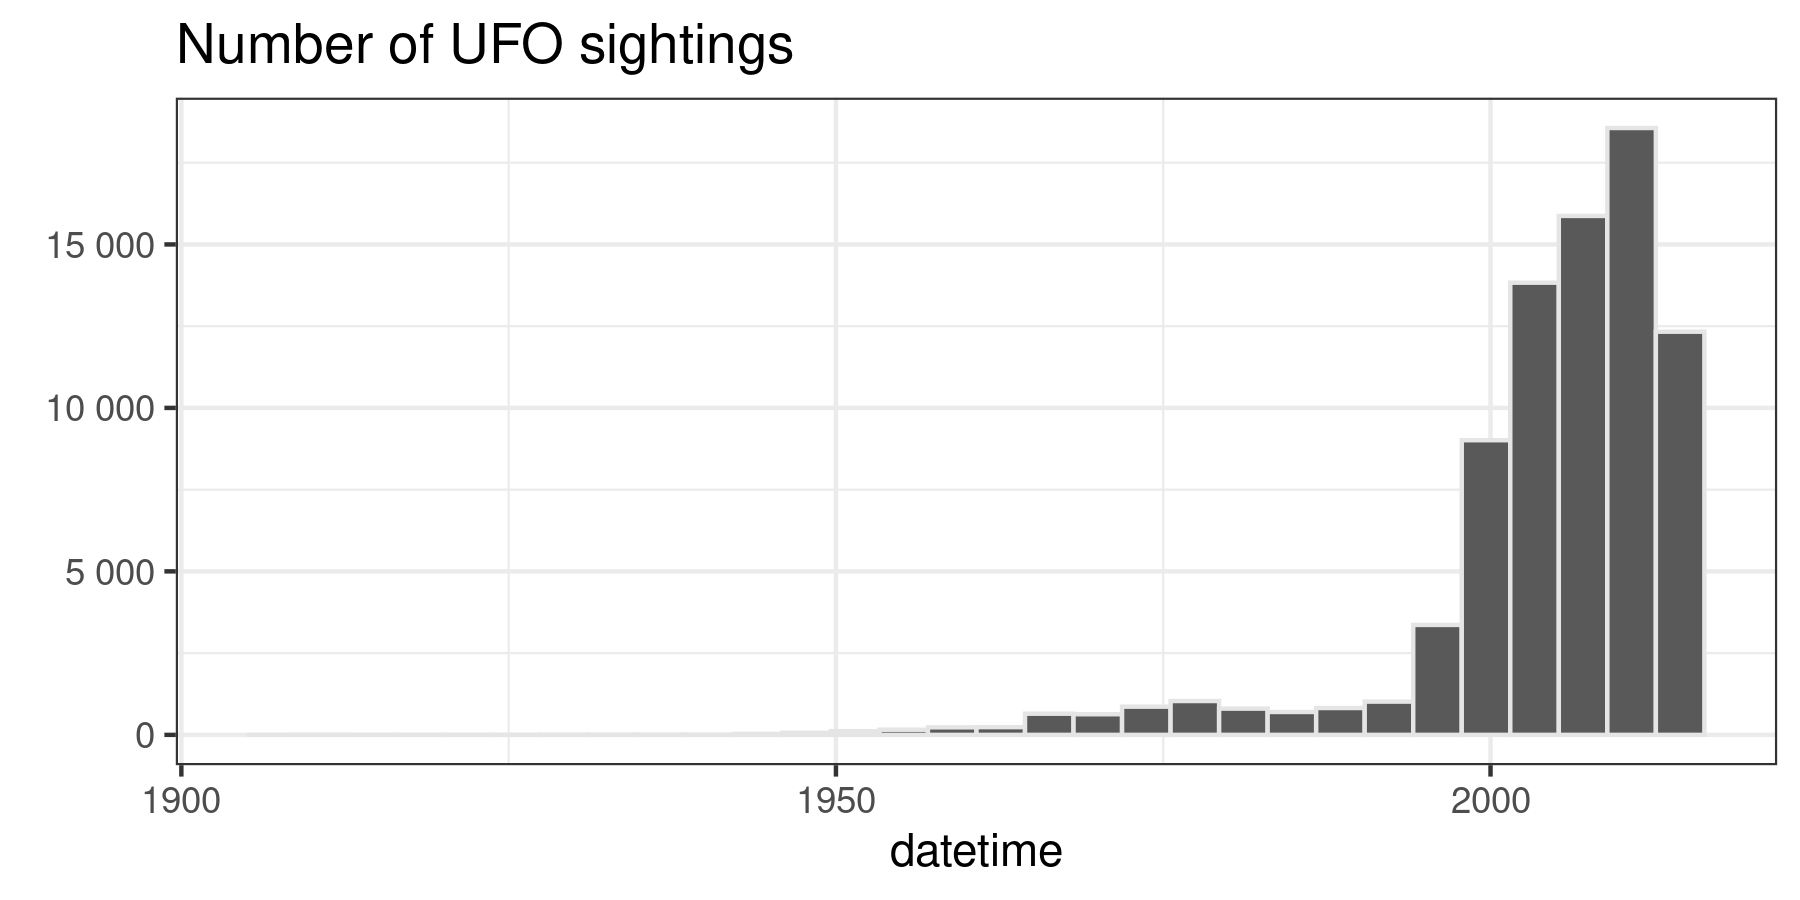

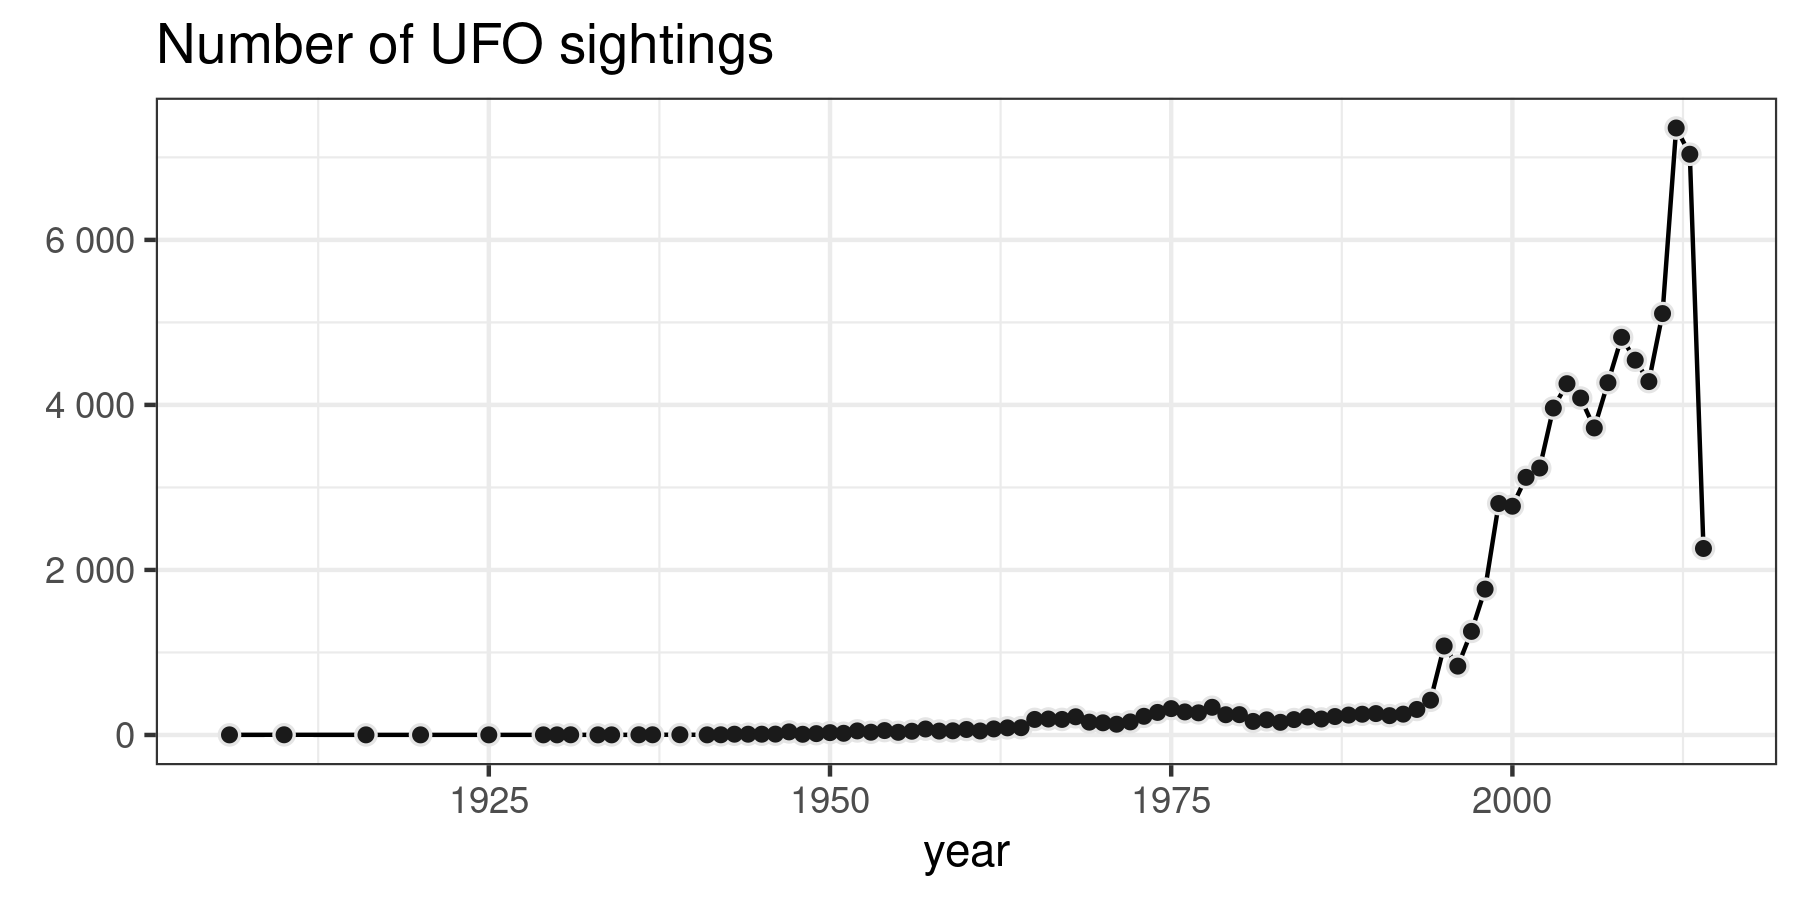

year  freq
0   2014  2260
1   2013  7038
2   2012  7356
3   2011  5107
4   2010  4283
5   2009  4542
6   2008  4819
7   2007  4269
8   2006  3721
9   2005  4083
10  2004  4257
11  2003  3962
12  2002  3235
13  2001  3122
14  2000  2772
15  1999  2805
16  1998  1767
17  1997  1255
18  1996   834
19  1995  1078
20  1994   421
21  1993   309
22  1992   252
23  1991   234
24  1990   259
25  1989   251
26  1988   241
27  1987   223
28  1986   193
29  1985   218

In [13]:
# number of sightings over time
ggshow("""
x$datetime <- as.POSIXct(x$datetime)
ggplot(x, aes(datetime)) + 
  geom_histogram(color="grey90") +
  ggtitle("Number of UFO sightings") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(6,3), dispwidth=700, x=x[["datetime"]])

tmp = x.datetime.dt.year.value_counts().sort_index(ascending=False)
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["year", "freq"]
ggshow("""
ggplot(x, aes(year, freq)) + 
  geom_line() +
  geom_point(size=2, color="grey90") +
  geom_point(size=1.25, color="grey10") +
  ggtitle("Number of UFO sightings") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw()
""", savesize=(6,3), dispwidth=700, x=tmp)

display(tmp.head(30))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


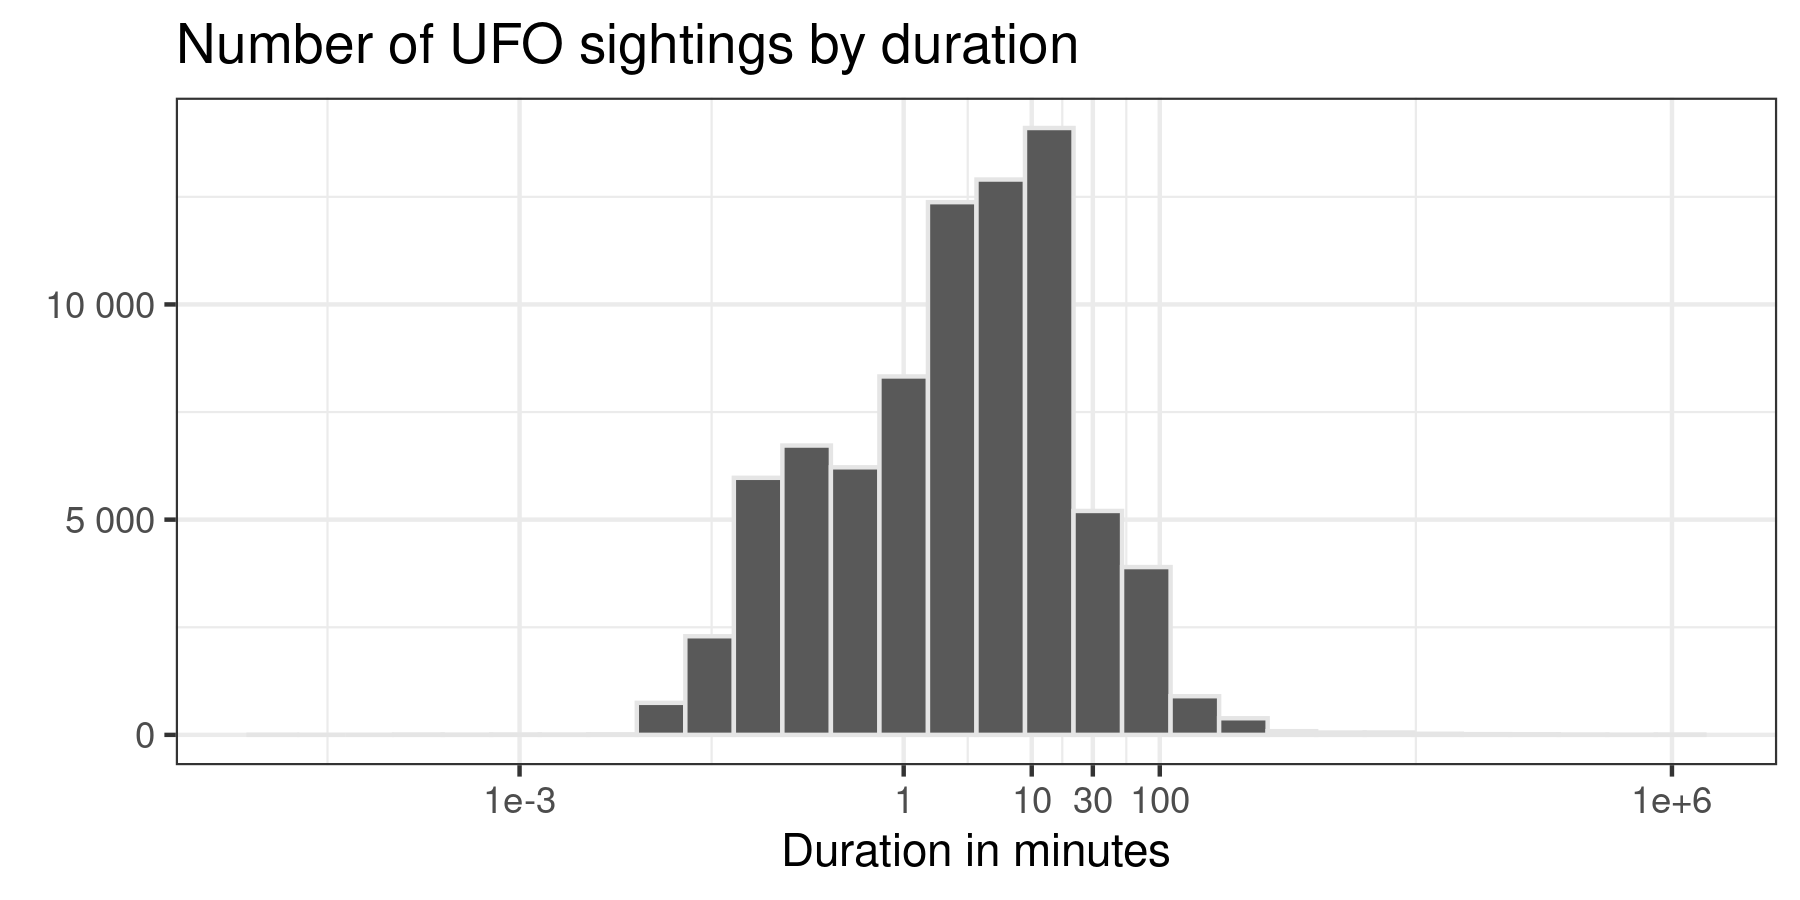

0.10     0.083333
0.15     0.166667
0.20     0.333333
0.25     0.500000
0.30     1.000000
0.35     1.000000
0.40     2.000000
0.45     2.000000
0.50     3.000000
0.55     4.000000
0.60     5.000000
0.65     5.000000
0.70    10.000000
0.75    10.000000
0.80    15.000000
0.85    20.000000
0.90    30.000000
0.95    60.000000
Name: duration_sec, dtype: float64

In [14]:
# duration distribution
ggshow("""
ggplot(x, aes(duration_sec/60)) + 
  geom_histogram(color="grey90") +
  ggtitle("Number of UFO sightings by duration") +
  #scale_x_continuous(breaks=[-3,0,3,6], labels=["1e-3", "1", "",]) +
  scale_x_log10(breaks=10^c(-3,0,1,log10(30),2,6), labels=c("1e-3", "1", "10", "30", "100", "1e+6")) +
  scale_y_continuous(labels=scales::number_format(1)) +
  xlab("Duration in minutes") +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(6,3), dispwidth=700, x=x.loc[~x.duration_sec.isna(), ["duration_sec"]])

(x.duration_sec / 60).quantile(q=np.arange(0.1,1,0.05))

light        16565
triangle      7865
circle        7608
fireball      6208
other         5649
unknown       5584
sphere        5387
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1962
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
delta            7
round            2
crescent         2
pyramid          1
flare            1
hexagon          1
dome             1
changed          1
Name: shape, dtype: int64

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


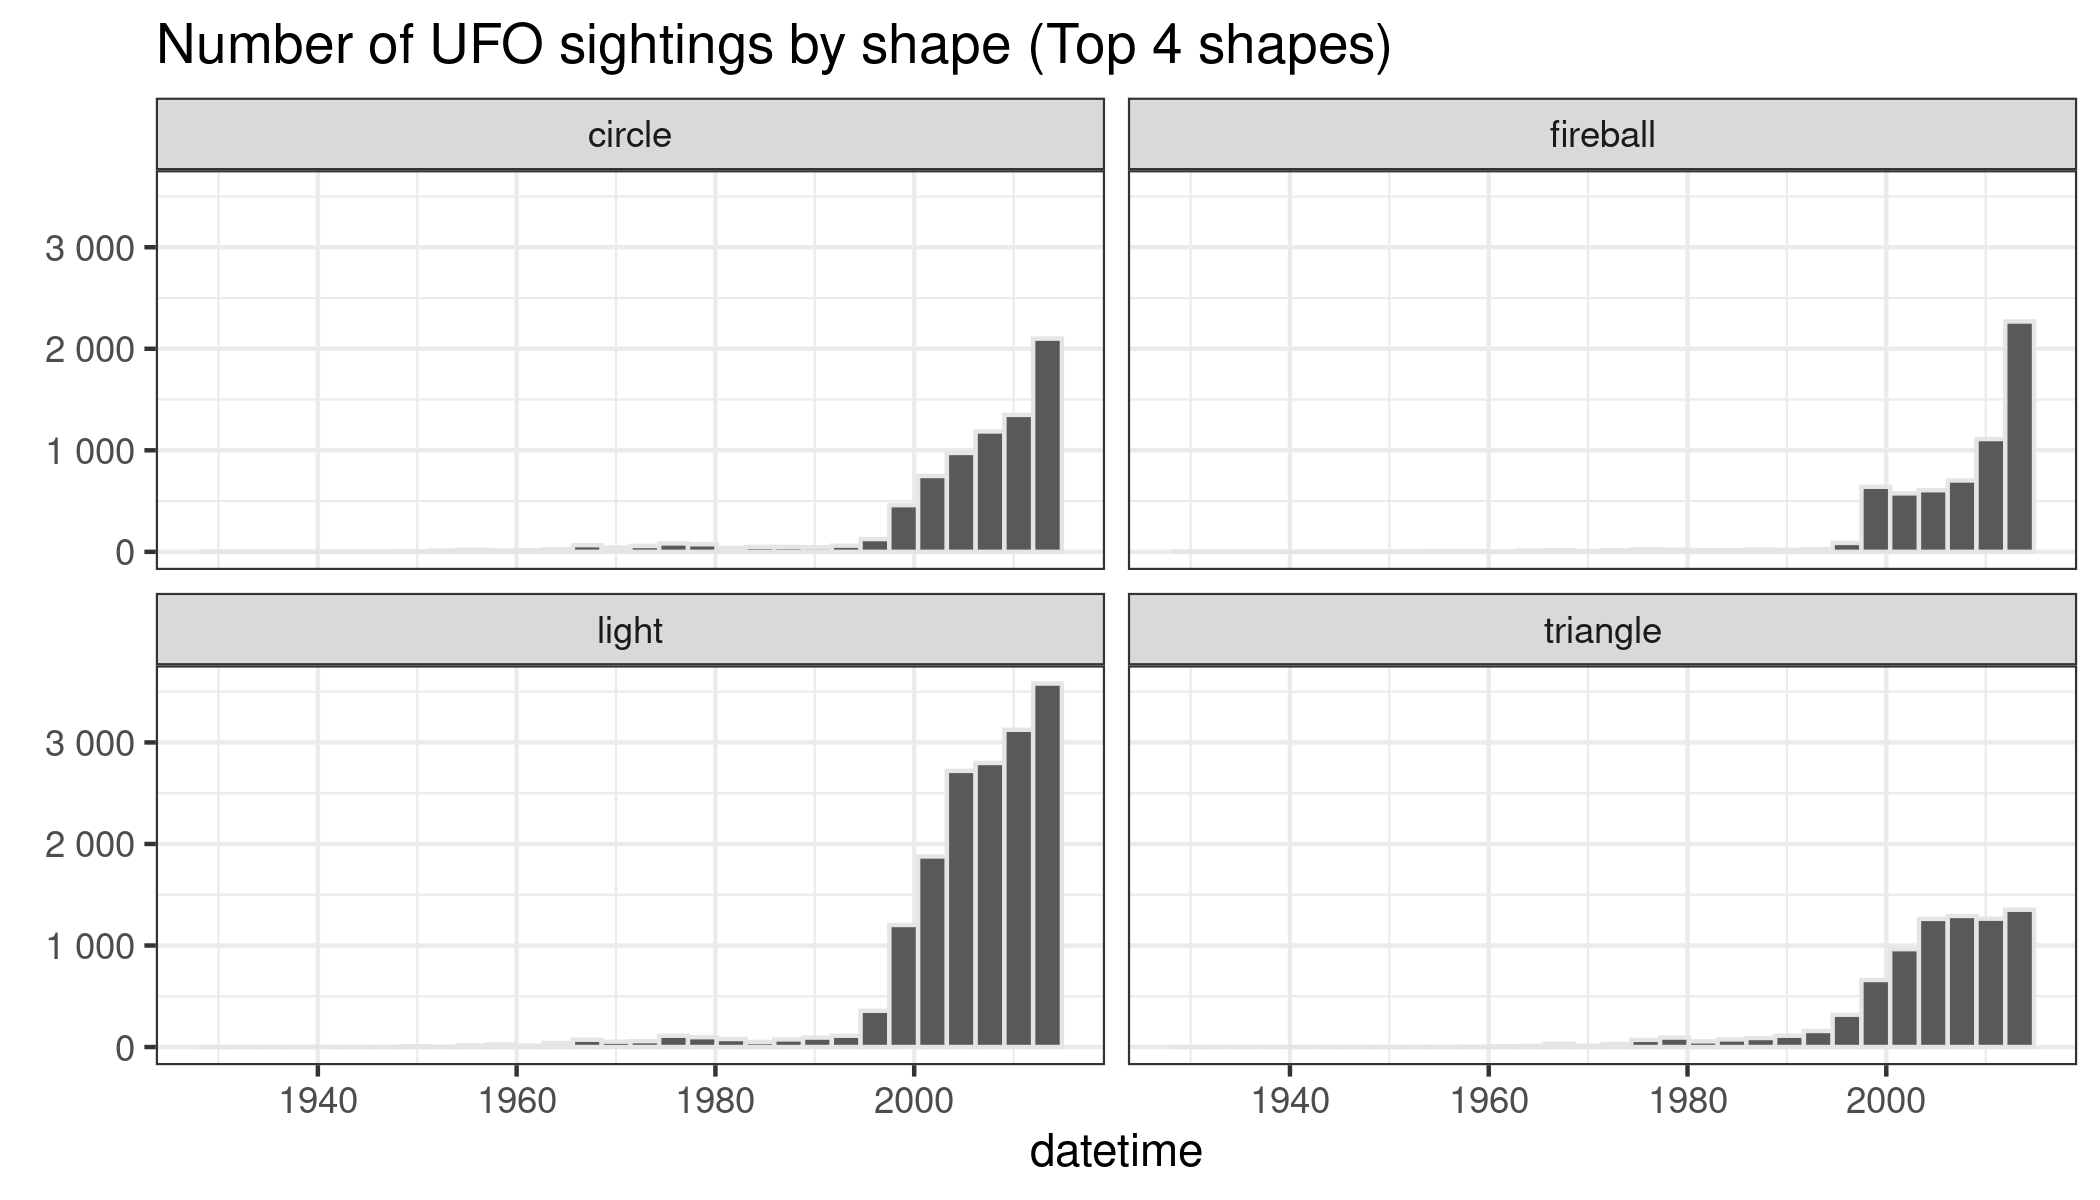

In [15]:
# shape distribution over time
tmp = x["shape"].value_counts()
display(tmp)

ggshow("""
x$datetime <- as.POSIXct(x$datetime)
ggplot(x, aes(datetime)) + 
  facet_wrap(vars(shape)) +
  geom_histogram(color="grey90", size=0.5) +
  ggtitle("Number of UFO sightings by shape (Top 4 shapes)") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(7,4), dispwidth=800, x=x.loc[x["shape"].isin(tmp.index[0:4]), ["datetime", "shape"]])
None

Zoom level 1 is chosen


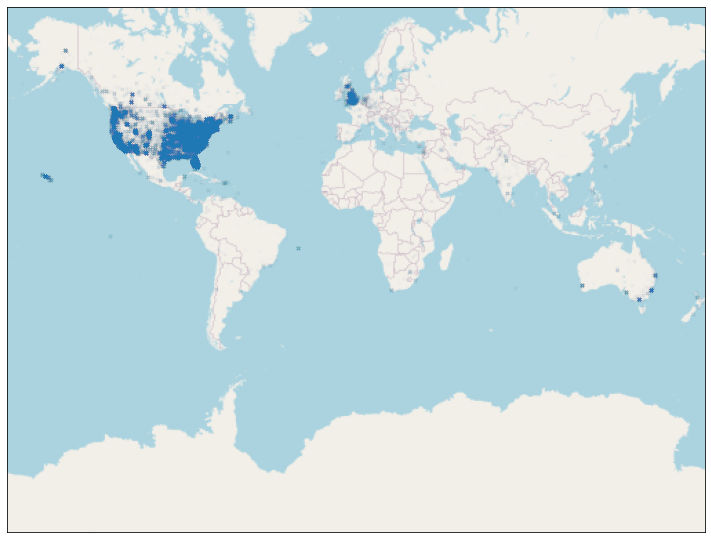

In [16]:
bounds = x.longitude.min(), x.latitude.min(), x.longitude.max(), x.latitude.max()
fig, ax = plt.subplots(figsize=(12.5, 10))
draw_map(bounds, ax=ax, extent_crs="webmap")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

ax.scatter(x.longitude_proj, x.latitude_proj, s=10, alpha=0.01, marker="x")
None

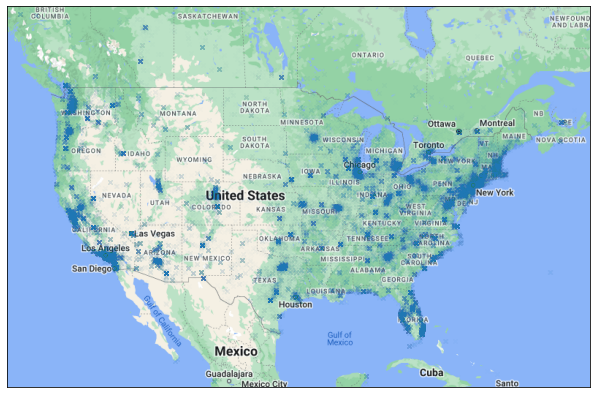

In [17]:
bounds = -130, 20, -60, 55
fig, ax = plt.subplots(figsize=(13, 7))
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3])
ax.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.01, marker="x")
None

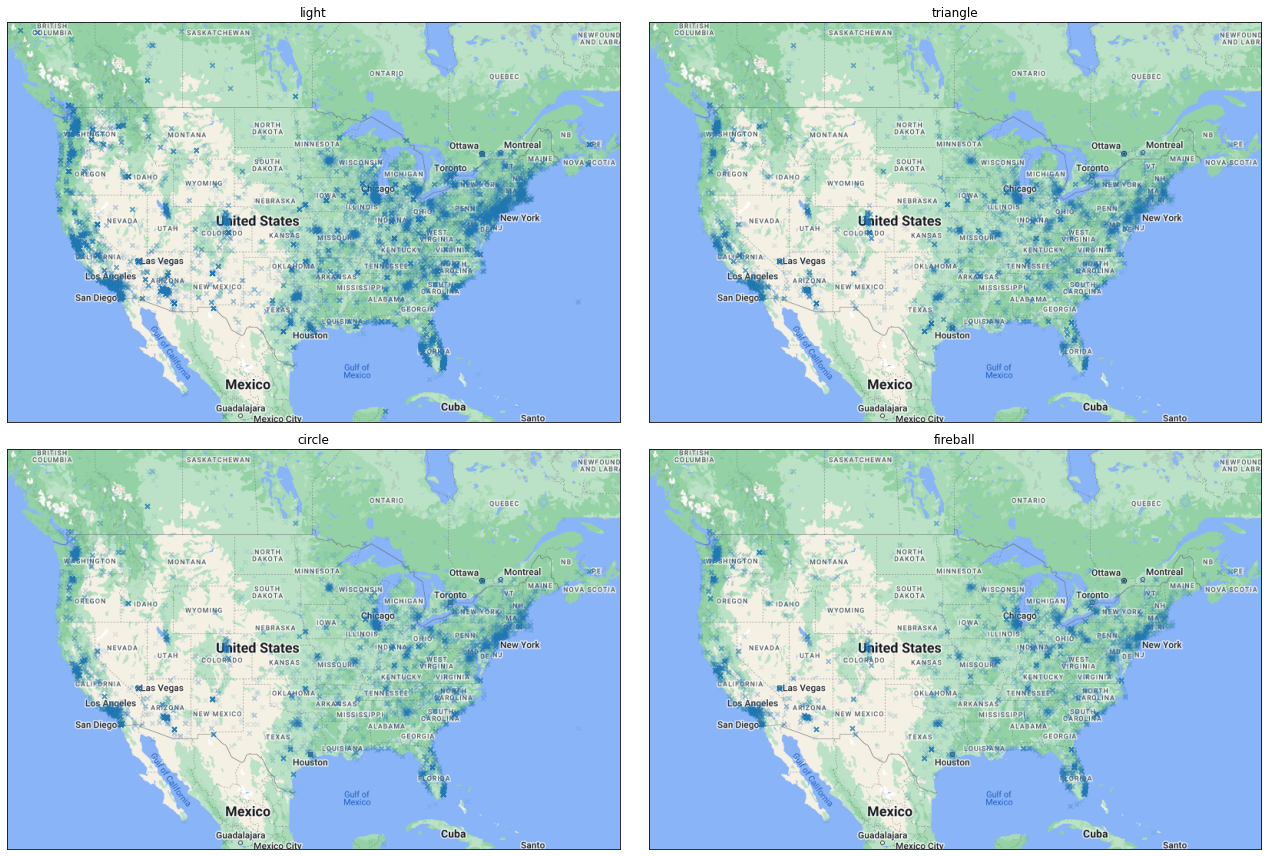

In [18]:
# by shape
bounds = -130, 20, -60, 55
tmp = x["shape"].value_counts()
shapes = tmp.sort_values(ascending=False).index[0:4]

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
for i, s in enumerate(shapes):
  r, c = int(i/2), i%2
  a = ax[r][c]
  a.set_title(s)
  draw_map(bounds, ax=a, extent_crs="webmap", z=4, tile="google")
  a.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)
  flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3]) & (x["shape"] == s)
  a.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.1, marker="x")
fig.tight_layout()
None

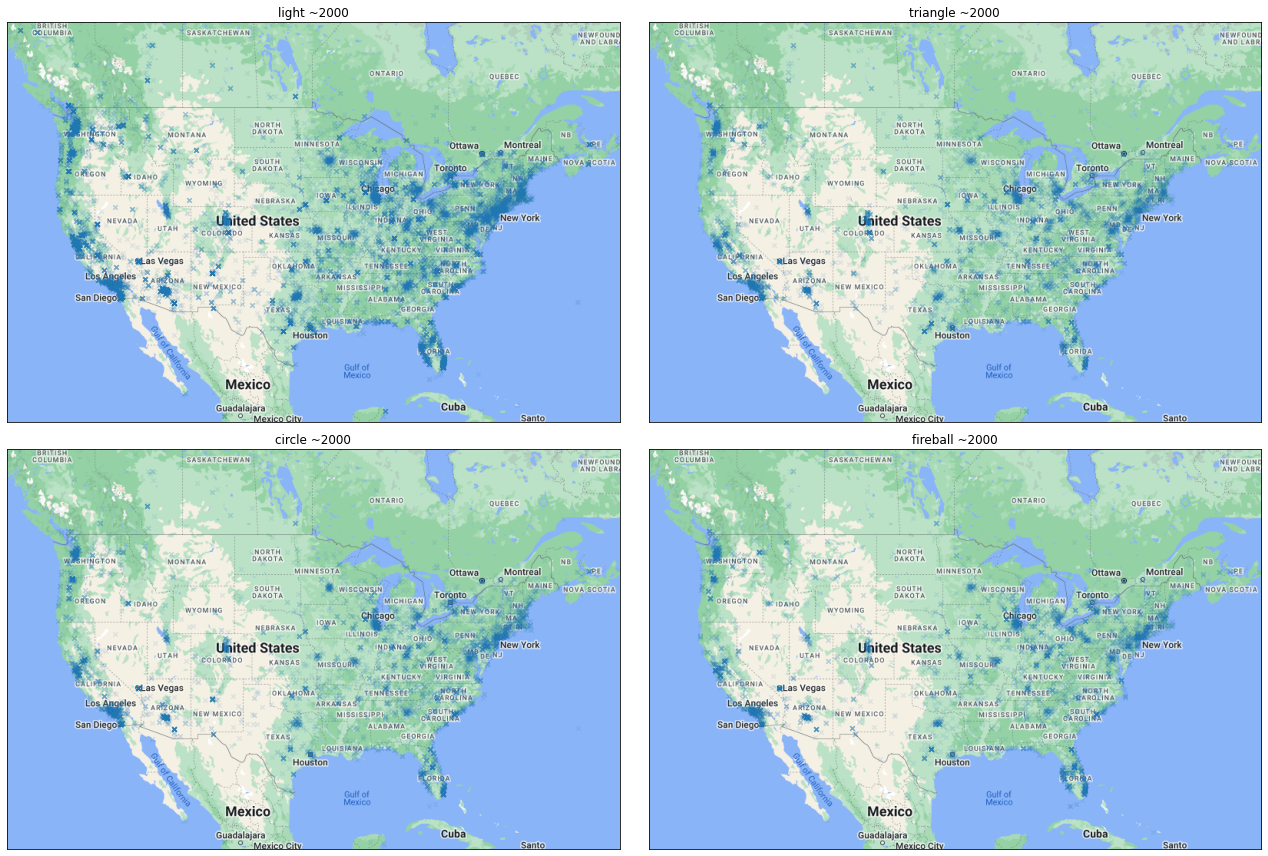

In [19]:
# by shape, since 2000 years
bounds = -130, 20, -60, 55
tmp = x["shape"].value_counts()
shapes = tmp.sort_values(ascending=False).index[0:4]

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
for i, s in enumerate(shapes):
  r, c = int(i/2), i%2
  a = ax[r][c]
  a.set_title("{} ~2000".format(s))
  draw_map(bounds, ax=a, extent_crs="webmap", z=4, tile="google")
  a.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)
  flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3]) & (x["shape"] == s) & (x.datetime.dt.year >= 2000)
  a.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.1, marker="x")
fig.tight_layout()
None

In [20]:
tmp = x.groupby(["state_name"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["state", "freq"]
display(tmp.head(10))

tmp = x[x.datetime.dt.year >= 2000].groupby(["state_name"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["state", "freq"]
display(tmp.head(10))

state  freq
0    California   9609
1    Washington   4265
2       Florida   4190
3         Texas   3689
4      New York   3253
5       Arizona   2703
6      Illinois   2648
7  Pennsylvania   2584
8          Ohio   2402
9      Michigan   2049

state  freq
0    California   7747
1       Florida   3573
2    Washington   3306
3         Texas   2912
4      New York   2526
5       Arizona   2238
6      Illinois   2172
7  Pennsylvania   2105
8          Ohio   1871
9      Michigan   1586

In [21]:
tmp = x.groupby(["state_name", "NAME"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["state", "county", "freq"]
display(tmp.head(20))

tmp = x[x.datetime.dt.year >= 2000].groupby(["state_name", "NAME"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["state", "county", "freq"]
display(tmp.head(20))

state          county  freq
0   California      Los Angeles  1988
1      Arizona         Maricopa  1398
2   Washington             King  1368
3   California        San Diego   900
4     Illinois             Cook   892
5   California           Orange   721
6     New York            Kings   552
7   California        Riverside   531
8       Nevada            Clark   523
9   California   San Bernardino   474
10       Texas           Harris   455
11  Washington        Snohomish   448
12  California      Santa Clara   404
13  Washington           Pierce   396
14      Oregon        Multnomah   388
15     Florida       Miami-Dade   373
16    New York          Suffolk   370
17  California       Sacramento   366
18     Florida       Palm Beach   329
19     Florida          Broward   327

state          county  freq
0       California      Los Angeles  1619
1          Arizona         Maricopa  1195
2       Washington             King  1013
3         Illinois             Cook   772
4       California        San Diego   733
5       California           Orange   611
6       California        Riverside   455
7           Nevada            Clark   424
8         New York            Kings   422
9       California   San Bernardino   381
10      Washington        Snohomish   364
11           Texas           Harris   353
12      California      Santa Clara   326
13          Oregon        Multnomah   321
14  South Carolina            Horry   313
15        New York          Suffolk   310
16      Washington           Pierce   304
17      California       Sacramento   302
18         Florida       Miami-Dade   298
19         Florida       Palm Beach   294

In [23]:
# since 2000
days = (x[x.datetime.dt.year >= 2000].datetime.max() - x[x.datetime.dt.year >= 2000].datetime.min())
print(days)

ranks = []

# total
tmp = x[x.datetime.dt.year >= 2000].groupby(["GEOID", "state_name", "NAME"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["geoid", "state", "county", "freq"]
tmp["ranking"] = np.arange(1, len(tmp)+1)
tmp["grouping"] = "all"
ranks.append(tmp)

# 30min+
tmp = x[(x.datetime.dt.year >= 2000) & (x.duration_sec >= 30*60)].groupby(["GEOID", "state_name", "NAME"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["geoid", "state", "county", "freq"]
tmp["ranking"] = np.arange(1, len(tmp)+1)
tmp["grouping"] = "30min+"
ranks.append(tmp)

# circle
tmp = x[(x.datetime.dt.year >= 2000) & (x["shape"] == "circle")].groupby(["GEOID", "state_name", "NAME"], as_index=False).size().rename(columns={"size": "freq"}).sort_values("freq", ascending=False).reset_index(drop=True)
tmp.columns = ["geoid", "state", "county", "freq"]
tmp["ranking"] = np.arange(1, len(tmp)+1)
tmp["grouping"] = "circle"
ranks.append(tmp)

ranks = pd.concat(ranks, ignore_index=True)
ranks["freq_per_day"] = ranks.freq / days.days
ranks

5241 days 18:44:00


geoid         state       county  freq  ranking grouping  freq_per_day
0     06037   California   Los Angeles  1619        1      all      0.308911
1     04013      Arizona      Maricopa  1195        2      all      0.228010
2     53033   Washington          King  1013        3      all      0.193284
3     17031     Illinois          Cook   772        4      all      0.147300
4     06073   California     San Diego   733        5      all      0.139859
...     ...           ...          ...   ...      ...      ...           ...
5628  31159     Nebraska        Seward     1     1309   circle      0.000191
5629  31177     Nebraska    Washington     1     1310   circle      0.000191
5630  32001       Nevada     Churchill     1     1311   circle      0.000191
5631  32013       Nevada      Humboldt     1     1312   circle      0.000191
5632  72073  Puerto Rico        Jayuya     1     1313   circle      0.000191

[5633 rows x 7 columns]

In [24]:
idx = pd.IndexSlice

tmp = ranks[ranks.ranking <= 10].pivot(index="ranking", columns="grouping").swaplevel(axis=1).sort_index(axis=1)
tmp = tmp.loc[:, idx[["all", "30min+", "circle"], ["geoid", "state", "county", "freq", "freq_per_day"]]]
tmp

grouping    all                                                 30min+  \
          geoid        state          county  freq freq_per_day  geoid   
ranking                                                                  
1         06037  California      Los Angeles  1619     0.308911  06037   
2         04013     Arizona         Maricopa  1195     0.228010  04013   
3         53033  Washington             King  1013     0.193284  17031   
4         17031    Illinois             Cook   772     0.147300  53033   
5         06073  California        San Diego   733     0.139859  06073   
6         06059  California           Orange   611     0.116581  06059   
7         06065  California        Riverside   455     0.086815  32003   
8         32003      Nevada            Clark   424     0.080901  45051   
9         36047    New York            Kings   422     0.080519  06065   
10        06071  California   San Bernardino   381     0.072696  36047   

grouping                                                 circle  \
                    state       county freq freq_per_day  geoid   
ranking                                                           
1             California   Los Angeles  185     0.035299  06037   
2                Arizona      Maricopa  181     0.034535  04013   
3               Illinois          Cook  102     0.019462  17031   
4             Washington          King   92     0.017554  53033   
5             California     San Diego   77     0.014692  06073   
6             California        Orange   65     0.012402  06059   
7                 Nevada         Clark   59     0.011257  06071   
8         South Carolina         Horry   57     0.010876  36103   
9             California     Riverside   56     0.010685  06065   
10              New York         Kings   54     0.010303  45051   

grouping                                                     
                    state          county freq freq_per_day  
ranking                                                      
1             California      Los Angeles  158     0.030147  
2                Arizona         Maricopa  114     0.021752  
3               Illinois             Cook   97     0.018508  
4             Washington             King   93     0.017745  
5             California        San Diego   86     0.016409  
6             California           Orange   74     0.014119  
7             California   San Bernardino   51     0.009731  
8               New York          Suffolk   47     0.008968  
9             California        Riverside   46     0.008777  
10        South Carolina            Horry   40     0.007632

In [25]:
# close look at specific state
geoid = "06037"
geo = cb.geometry[cb.GEOID == geoid].item()
county = cb.NAME[cb.GEOID == geoid].item()

lon, lat = geo.centroid.x, geo.centroid.y
m = folium.Map((lat, lon), zoom_start=9)
folium.GeoJson(data=geo, style_function=lambda x: {"color":"#050505", "fillOpacity":0.05}).add_to(m)

tmp = x[(x.datetime.dt.year >= 2000) & (x.GEOID == geoid)]

for _, row in tqdm(tmp.iterrows()):
  if row["shape"] == "circle":
    icon = folium.Icon(color="orange", icon="circle", prefix="fa")
  elif row["shape"] == "triangle":
    icon = folium.Icon(color="green", icon="caret-up", prefix="fa")
  elif row["shape"] == "light":
    icon = folium.Icon(color="blue", icon="lightbulb-o", prefix="fa")
  elif row["shape"] == "fire":
    icon = folium.Icon(color="red", icon="fire", prefix="fa")
  else:
    icon = folium.Icon(color="gray", icon="question", prefix="fa")
  folium.Marker(location=[row.latitude, row.longitude],
                popup="{} {}".format(row.comments, row.datetime),
                icon=icon).add_to(m) 
m.save(os.path.join(outdir, "{}_{}.html".format(geoid, county)))
m

1619it [00:00, 2227.79it/s]


In [26]:
geoid = "17031"
geo = cb.geometry[cb.GEOID == geoid].item()
county = cb.NAME[cb.GEOID == geoid].item()

lon, lat = geo.centroid.x, geo.centroid.y
m = folium.Map((lat, lon), zoom_start=9)
folium.GeoJson(data=geo, style_function=lambda x: {"color":"#050505", "fillOpacity":0.05}).add_to(m)

tmp = x[(x.datetime.dt.year >= 2000) & (x.GEOID == geoid)]

for _, row in tqdm(tmp.iterrows()):
  if row["shape"] == "circle":
    icon = folium.Icon(color="orange", icon="circle", prefix="fa")
  elif row["shape"] == "triangle":
    icon = folium.Icon(color="green", icon="caret-up", prefix="fa")
  elif row["shape"] == "light":
    icon = folium.Icon(color="blue", icon="lightbulb-o", prefix="fa")
  elif row["shape"] == "fire":
    icon = folium.Icon(color="red", icon="fire", prefix="fa")
  else:
    icon = folium.Icon(color="gray", icon="question", prefix="fa")
  folium.Marker(location=[row.latitude, row.longitude],
                popup="{} {}".format(row.comments, row.datetime),
                icon=icon).add_to(m) 
m.save(os.path.join(outdir, "{}_{}.html".format(geoid, county)))
m

772it [00:00, 1646.11it/s]


In [27]:
# clustering
tmp = x[x.datetime.dt.year >= 2000].copy()
data = np.radians(tmp[["longitude", "latitude"]].values)
max_distance = 10
min_samples = 500

dbscan = DBSCAN(eps=max_distance/6371, min_samples=min_samples, metric="haversine")
dbscan.fit(data)
tmp["clusterid"] = dbscan.labels_
tmp.clusterid.value_counts()
display(tmp)

def haversine(lon1: float, lat1: float, lon2: float, lat2: float)-> float:
    """
    Compute haversince distance in kilometers
    """
    if (lon1 is None) or (lat1 is None) or (lon2 is None) or (lat2 is None):
        return None
    # Great-circle distance formula
    # https://en.wikipedia.org/wiki/Great-circle_distance
    radius = 6371
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    tmp = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(dlon)
    tmp = np.clip(tmp, -1, 1)  # clip to [-1, 1] to avoid domain error with 1.000000002 or sort
    c = np.arccos(tmp)
    return radius * c


centers = tmp[["longitude", "latitude", "clusterid"]].groupby("clusterid", as_index=False).mean().rename(
    columns={"longitude":"longitude_center", "latitude":"latitude_center"})
tmp = pd.merge(tmp, centers, on="clusterid")
#tmp["deviation"] = [haversine(t.longitude, t.latitude, t.longitude_center, t.latitude_center) for _, t in tqdm(tmp.iterrows())]
tmp["deviation"] = haversine(tmp.longitude, tmp.latitude, tmp.longitude_center, tmp.latitude_center)
devs = tmp.groupby("clusterid", as_index=False).agg(
     mean_deviation=("deviation", "mean")
    ,max_deviation=("deviation", "max")
)
clusters = pd.merge(centers, devs, on="clusterid")
clusters

datetime                           city state country  \
93    2000-10-10 03:00:00                     perryville    mo      us   
94    2000-10-10 06:15:00                  boynton beach    fl      us   
95    2000-10-10 07:30:00              victoria (canada)    bc      ca   
96    2000-10-10 16:00:00                         jueanu    wi     NaN   
97    2000-10-10 20:20:00  valley park area of st. louis    mo     NaN   
...                   ...                            ...   ...     ...   
80327 2013-09-09 21:15:00                      nashville    tn      us   
80328 2013-09-09 22:00:00                          boise    id      us   
80329 2013-09-09 22:00:00                           napa    ca      us   
80330 2013-09-09 22:20:00                         vienna    va      us   
80331 2013-09-09 23:00:00                         edmond    ok      us   

          shape  duration_sec duration_word  \
93         oval         180.0     3 minutes   
94        other          10.0    10 seconds   
95     cylinder          30.0     30seconds   
96     triangle          45.0    45 seconds   
97         oval          15.0    15 seconds   
...         ...           ...           ...   
80327     light         600.0    10 minutes   
80328    circle        1200.0    20 minutes   
80329     other        1200.0          hour   
80330    circle           5.0     5 seconds   
80331     cigar        1020.0    17 minutes   

                                                comments date_posted  \
93     The craft was big&#44 orange&#44 and oval shaped.  2000-12-02   
94     Unusual light formation moving extremely fast ...  2000-12-02   
95                                 Smooth Shiny Cylinder  2000-12-02   
96                                5 bight light V shaped  2000-12-02   
97     Driving on Hyw.141 at Hyw. 44 and going East&#...  2000-12-02   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...  2013-09-30   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...  2013-09-30   
80329                                       Napa UFO&#44  2013-09-30   
80330  Saw a five gold lit cicular craft moving fastl...  2013-09-30   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...  2013-09-30   

        latitude  ...        AFFGEOID  GEOID        NAME LSAD         ALAND  \
93     37.724167  ...  0500000US29157  29157       Perry   06  1.228574e+09   
94     26.525000  ...  0500000US12099  12099  Palm Beach   06  5.090938e+09   
95     46.216667  ...             NaN    NaN         NaN  NaN           NaN   
96     43.405550  ...  0500000US55027  55027       Dodge   06  2.268073e+09   
97     38.627003  ...  0500000US29510  29510   St. Louis   25  1.599151e+08   
...          ...  ...             ...    ...         ...  ...           ...   
80327  36.165833  ...  0500000US47037  47037    Davidson   06  1.304033e+09   
80328  43.613611  ...  0500000US16001  16001         Ada   06  2.724688e+09   
80329  38.297222  ...  0500000US06055  06055        Napa   06  1.938114e+09   
80330  38.901111  ...  0500000US51059  51059     Fairfax   06  1.012684e+09   
80331  35.652778  ...  0500000US40109  40109    Oklahoma   06  1.835846e+09   

             AWATER   state_name state_code state_fips clusterid  
93     2.539486e+07    Missouri         MO          29        -1  
94     1.081432e+09     Florida         FL          12        -1  
95              NaN          NaN        NaN        NaN        -1  
96     8.130812e+07   Wisconsin         WI          55        -1  
97     1.121112e+07    Missouri         MO          29        -1  
...             ...          ...        ...        ...       ...  
80327  5.659044e+07   Tennessee         TN          47        -1  
80328  2.217618e+07       Idaho         ID          16        -1  
80329  1.043008e+08  California         CA          06        -1  
80330  4.012692e+07    Virginia         VA          51        -1  
80331  2.473

clusterid  longitude_center  latitude_center  mean_deviation  max_deviation
0         -1        -85.951635        38.055554     2065.241905   18783.503674
1          0       -118.274797        34.075762        8.227295      27.179257
2          1        -74.022128        40.758579       10.606087      59.540094
3          2        -87.774099        41.918119       44.012053     287.312108
4          3        -80.180661        26.000710       21.764923      40.934715
5          4       -122.328788        47.577735        5.535661      28.426678
6          5       -122.272521        47.717814       10.409504      16.795911

In [28]:
colors = ['lightblue', 'pink', 'cadetblue', 'blue', 'green', 'beige',
          'white', 'orange', 'lightred', 'red', 'darkpurple', 'purple',
          'darkblue', 'lightgreen', 'darkred', 'darkgreen', 'black', 'lightgray']

m = folium.Map((32, -95), zoom_start=4)
for _, row in tqdm(tmp.iterrows()):
  if row.clusterid == -1:
    continue
  if random.random() < 0.8:  # skip some records to reduce memory usage
    continue
  color = colors[row.clusterid] if row.clusterid < len(colors) else "gray"
  icon = folium.Icon(color=color)
  folium.Marker(location=[row.latitude, row.longitude],
                popup="{} {}".format(row.comments, row.datetime),
                icon=icon).add_to(m)
m.save(os.path.join(outdir, "cluster-{}-{}.html".format(max_distance, min_samples)))
m

64826it [00:16, 3999.72it/s]


In [29]:
# Japan
bounds = 122, 20, 153, 45
lon, lat = 0.5*(bounds[0] + bounds[2]), 0.5*(bounds[1] + bounds[3])
m = folium.Map((lat, lon), zoom_start=5)
flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3])
for _, row in tqdm(x[flg].iterrows()):
  if row.datetime.year >= 2000:
    color = "blue"
  else:
    color = "orange"
  icon = folium.Icon(color=color)
  folium.Marker(location=[row.latitude, row.longitude],
                popup="{} {}".format(row.comments, row.datetime),
                icon=icon).add_to(m)
m.save(os.path.join(outdir, "japan.html"))
m

72it [00:00, 166.06it/s]
